<a href="https://colab.research.google.com/github/JadeKim/Quanvolution-lab/blob/main/jade_cnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [13]:
torch.cuda.is_available()

False

In [2]:
trn_dataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.1307,), (0.3081,)) # image, label
                             ])) 

val_dataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))


Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw




Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw




Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Batch iterator
batch_size = 64
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [4]:
# construct model on cuda if available
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 6, 5, 1) # 6@24*24
        # activation ReLU
        pool1 = nn.MaxPool2d(2) # 6@12*12
        conv2 = nn.Conv2d(6, 16, 5, 1) # 16@8*8
        # activation ReLU
        pool2 = nn.MaxPool2d(2) # 16@4*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(16*4*4, 120)
        # activation ReLU
        fc2 = nn.Linear(120, 84)
        # activation ReLU
        fc3 = nn.Linear(84, 10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # cuda
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [6]:
cnn = CNNClassifier()
print(cnn)

CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [7]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 2
num_batches = len(trn_loader)

trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, data in enumerate(trn_loader):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    val_output = cnn(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader)
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            trn_loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 1/2 | step: 100/938 | trn loss: 1.9917 | val loss: 1.7558
epoch: 1/2 | step: 200/938 | trn loss: 1.7111 | val loss: 1.6971
epoch: 1/2 | step: 300/938 | trn loss: 1.7037 | val loss: 1.6957
epoch: 1/2 | step: 400/938 | trn loss: 1.6389 | val loss: 1.6084
epoch: 1/2 | step: 500/938 | trn loss: 1.6062 | val loss: 1.5938
epoch: 1/2 | step: 600/938 | trn loss: 1.5937 | val loss: 1.5997
epoch: 1/2 | step: 700/938 | trn loss: 1.5898 | val loss: 1.5856
epoch: 1/2 | step: 800/938 | trn loss: 1.5893 | val loss: 1.5796
epoch: 1/2 | step: 900/938 | trn loss: 1.5864 | val loss: 1.5919
epoch: 2/2 | step: 100/938 | trn loss: 1.5733 | val loss: 1.5788
epoch: 2/2 | step: 200/938 | trn loss: 1.5791 | val loss: 1.5759
epoch: 2/2 | step: 300/938 | trn loss: 1.5813 | val loss: 1.5713
epoch: 2/2 | step: 400/938 | trn loss: 1.5847 | val loss: 1.5754
epoch: 2/2 | step: 500/938 | trn loss: 1.5760 | val loss: 1.5718
epoch: 2/2 | step: 600/938 | trn loss: 1.5757 | val loss: 1.5744
epoch: 2/2 | step: 700/93

Text(0, 0.5, 'loss')

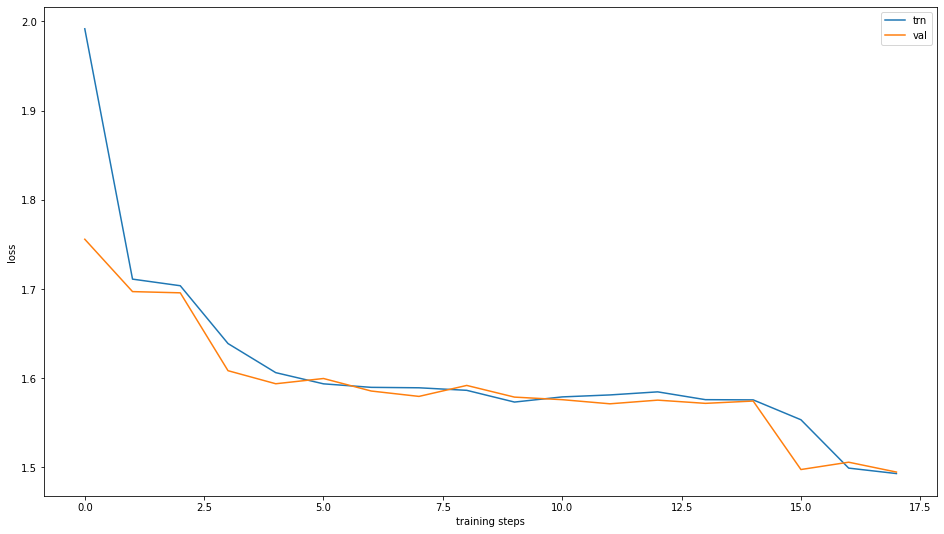

In [14]:
plt.figure(figsize=(16,9))
x_range = range(len(trn_loss_list))
plt.plot(x_range, trn_loss_list, label="trn")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")

In [15]:
# val acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(val_loader):
        val_x, val_label = val
        if use_cuda:
            val_x = val_x.cuda()
            val_label =val_label.cuda()
        val_output = cnn(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("acc: {:.2f}".format(corr_num / total_num * 100))

acc: 96.90
